In [1]:
import os

import numpy as np 

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.stats import mad_std, gaussian_sigma_to_fwhm
from astropy.table import Table
from astropy.modeling import models, fitting
from astropy.nddata import Cutout2D

from astropy.stats import gaussian_fwhm_to_sigma

from photutils import DAOStarFinder
from photutils import aperture_photometry, CircularAperture

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Local Paths (NB Inputs)

In [3]:
abell370_f435w_epoch2_drz_file = "/Users/rgeda/project/data/lcbg/hlsp_frontier_hst_acs-30mas_abell370/hlsp_frontier_hst_acs-30mas_abell370-hffpar_f435w_v1.0-epoch2_drz.fits"

In [4]:
input_data_path = abell370_f435w_epoch2_drz_file

output_path = "{}_catalog.csv".format(os.path.splitext(os.path.basename(input_data_path))[0])

print("Output: ", output_path)

Output:  hlsp_frontier_hst_acs-30mas_abell370-hffpar_f435w_v1.0-epoch2_drz_catalog.csv


# Load Data

In [5]:
hdul = fits.open(abell370_f435w_epoch2_drz_file)
hdu = hdul[0]

In [6]:
data = hdu.data
header = hdu.header

Plot image

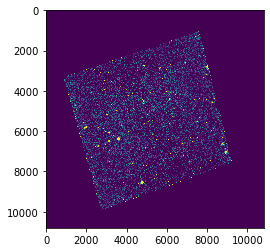

In [7]:
plt.imshow(data, vmin=0, vmax=2.9534784e-05*90)

In [8]:
mean_noise = 4.5e-5

In [9]:
data -= mean_noise

# Estimate FWHM

In [10]:

def cutout(image, x, y, dx, dy=None, vmin=None, vmax=None):
    """
    Clip and make a cutout of an image

    Parameters
    ----------
    image : array like
        Input image.
    x, y : int
        Center of cutout. The indexing is array[y, x] and
        x is the x axis when plotted.
    dx, dy : int
        Size of image in x and y direction. The indexing is array[y, x] and
        x is the x axis when plotted. If dy is not provided it will be set
        to the same size as dx.
    vmin, vmax : float
        max and min values to clip the input image.


    Returns
    -------
    Copied array
        Clipped and cropped image.
    """

    if dy is None:
        dy = dx

    vmin = vmin if vmin else image.min()
    vmax = vmax if vmax else image.max()
    image = np.clip(image, vmin, vmax)

    return image[y - dy // 2:y + dy // 2, x - dx // 2:x + dx // 2].copy()


In [11]:

def measure_fwhm(image, plot=True):
    """
    Find the 2D FWHM of a background/continuum subtracted cutout image of a target.
    The target should be centered and cropped in the cutout.
    Use lcbg.utils.cutout for cropping targets.
    FWHM is estimated using the sigmas from a 2D gaussian fit of the target's flux.
    The FWHM is returned as a tuple of the FWHM in the x and y directions.

    Parameters
    ----------
    image : array like
        Input background/continuum subtracted cutout image.
    plot : bool
        To plot fit or not.

    Returns
    -------
    tuple : tuple of floats 
        FWHM in x and y directions.
    """

    # Find FWHM
    # ----------

    # Estimate center of target
    y_mean, x_mean = np.array(image.shape) // 2  # Center guess

    # Make x and y grid to fit to
    y_arange, x_arange = np.mgrid[:image.shape[0], :image.shape[1]]

    # Create model to fit
    model = models.Gaussian2D(amplitude=image.max(),
                              x_mean=x_mean,
                              y_mean=y_mean, )

    # Fit model to grid
    fit = fitting.LevMarLSQFitter()
    fitted_line = fit(model, x_arange, y_arange, image)

    # Find fitted center
    x_mean, y_mean = [i.value for i in [fitted_line.x_mean, fitted_line.y_mean]]

    # Estimate FWHM using gaussian_sigma_to_fwhm
    x_fwhm = fitted_line.x_stddev * gaussian_sigma_to_fwhm
    y_fwhm = fitted_line.y_stddev * gaussian_sigma_to_fwhm

    # Find the mean of the x and y direction
    mean_fwhm = np.mean([x_fwhm, y_fwhm])
    mean_fwhm = int(np.round(mean_fwhm))

    # Print info about fit and FWHM
    # ------------------------------
    
    print("Image Max: {}".format(image.max()))
    print("Amplitude: {}".format(fitted_line.amplitude.value))
    print("Center: ({}, {})".format(x_mean, y_mean))
    print("Sigma = ({}, {})".format(fitted_line.x_stddev.value,
                                    fitted_line.y_stddev.value, ))

    print("Mean FWHM: {} Pix ".format(mean_fwhm))
    print("FWHM: (x={}, y={}) Pix ".format(x_fwhm, y_fwhm))

    if plot:
        fig = plt.figure(figsize=(12, 12))

        # Plot input image with FWHM and center
        # -------------------------------------
        
        ax0 = fig.add_subplot(221)

        ax0.imshow(image, cmap='gray_r')
        ax0.axvline(x_mean, label="Center")
        ax0.axhline(y_mean)

        ax0.axvline(x_mean - x_fwhm / 2, c='c', linestyle="--", label="X FWHM")
        ax0.axvline(x_mean + x_fwhm / 2, c='c', linestyle="--")

        ax0.axhline(y_mean - y_fwhm / 2, c='g', linestyle="--", label="Y FWHM")
        ax0.axhline(y_mean + y_fwhm / 2, c='g', linestyle="--")

        ax0.set_title("Center and FWHM Plot")
        ax0.set_xlabel("X Pixel")
        ax0.set_ylabel("Y Pixel")

        ax0.legend()

        # Plot residuals
        # ---------------
        
        ax1 = fig.add_subplot(222)
        ax1.imshow(image - fitted_line(x_arange, y_arange))

        ax1.set_title("Residual (Image - Fit)")
        ax1.set_xlabel("X Pixel")
        ax1.set_ylabel("Y Pixel")

        # Prepare fine grid
        # -----------------

        # We need a fine grid to fill in inter-pixel values
        # Oversample by a factor of 10

        hm = fitted_line(x_mean, y_mean) / 2.
        y_arange_fine, x_arange_fine = np.mgrid[:image.shape[0] * 10, :image.shape[1] * 10] / 10
        x_slice_fine = fitted_line(x_arange_fine[1, :], y_mean)
        y_slice_fine = fitted_line(np.ones_like(y_arange_fine[:, 1]) * x_mean, y_arange_fine[:, 1])

        # Plot X fit
        # ----------

        ax2 = fig.add_subplot(223)

        ax2.plot(x_arange_fine[1, :], x_slice_fine, c='r')
        ax2.scatter(x_arange[1, :], image[int(np.round(y_mean)), :], c='black')

        ax2.axvline(x_mean, linestyle="-", label="Center")
        ax2.axvline(x_mean - x_fwhm / 2, c='c', linestyle="--", label="X FWHM")
        ax2.axvline(x_mean + x_fwhm / 2, c='c', linestyle="--")

        ax2.set_title("X Cross Section")
        ax2.set_xlabel("X Pixel")
        ax2.set_ylabel("Flux")
        ax2.axhline(hm, c="black", linestyle="--", label="Half Max")

        ax2.legend()

        # Plot Y fit
        # ----------

        ax3 = fig.add_subplot(224)

        ax3.plot(y_arange_fine[:, 1], y_slice_fine, c='r')
        ax3.scatter(y_arange[:, 1], image[:, int(np.round(x_mean))], c='black')

        ax3.axvline(y_mean, linestyle="-", label="Center")
        ax3.axvline(y_mean - y_fwhm / 2, c='g', linestyle="--", label="Y FWHM")
        ax3.axvline(y_mean + y_fwhm / 2, c='g', linestyle="--")
        ax3.axhline(hm, c="black", linestyle="--", label="Half Max")

        ax3.set_title("Y Cross Section")
        ax3.set_xlabel("Y Pixel")
        ax3.set_ylabel("Flux")

        ax3.legend()

        plt.show()

    return x_fwhm, y_fwhm

In [12]:
# Saved snippit 
"""
    hm = fitted_line(x_mean, y_mean) / 2.
    
    x_hm = abs(x_slice - hm).argmin()
    x_fwhm = abs(x_mean - x_hm) * 2

    y_hm = abs(y_slice - hm).argmin()
    y_fwhm = abs(y_mean - y_hm) * 2
""";

## Test FWHM function:

Create fake data using a models.Gaussian2D. The FWHM will be rigged by using the model's `x_stddev` and `y_stddev` params. We then add random noise to the data.  

(200, 400)


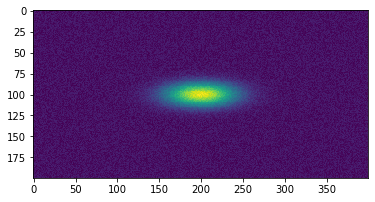

Correct FWHM: 70.64460135092848 23.548200450309494


In [21]:
model = models.Gaussian2D(amplitude=100, x_mean=200, y_mean=100, x_stddev=30, y_stddev=10)

y, x = np.mgrid[:200, :400]

noise_image = np.random.rand(200,400)*10
image = model(x, y) + noise_image

#image = cutout(image, 200, 100, 400, 200, vmax=30)

print(image.shape)
plt.imshow(image)
plt.show()
print("Correct FWHM:", 30 * gaussian_sigma_to_fwhm, 10 * gaussian_sigma_to_fwhm)

#### Run function 

We subtract the background noise (scalar) and call the function 

Image Max: 104.11883604694654
Amplitude: 100.09158335741185
Center: (200.02903530897981, 99.98704969388176)
Sigma = (29.952611811547744, 10.004672178796417)
Mean FWHM: 47 Pix 
FWHM: (x=70.5330106948634, y=23.559202590593266) Pix 


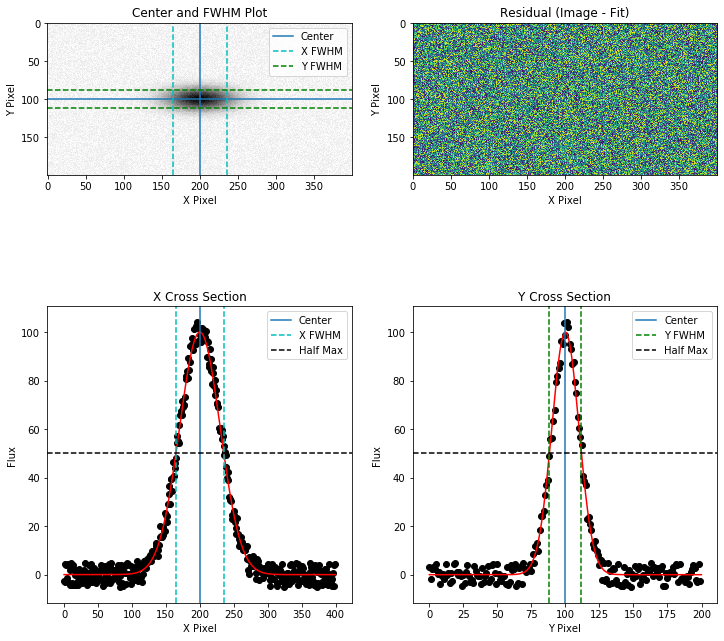

(70.5330106948634, 23.559202590593266)

In [14]:
measure_fwhm(image - noise_image.mean())

Residuals are near zero and FWHM estimates are very close to rigged value!

## Bright star:

We center and crop a bright star in the image, then we do 2 calls to the function. In the first we attempt to find the FWHM of the star without clipping. Next we clip the max value of the image to expose the spread out PSF of the same star (we fit the base of the star). 

Image Max: 21.09130096435547
Amplitude: 20.146042506154267
Center: (9.348103012229137, 9.81507494581163)
Sigma = (1.5303130061584922, 1.4956896058788336)
Mean FWHM: 4 Pix 
FWHM: (x=3.603611742073588, y=3.522079865067918) Pix 


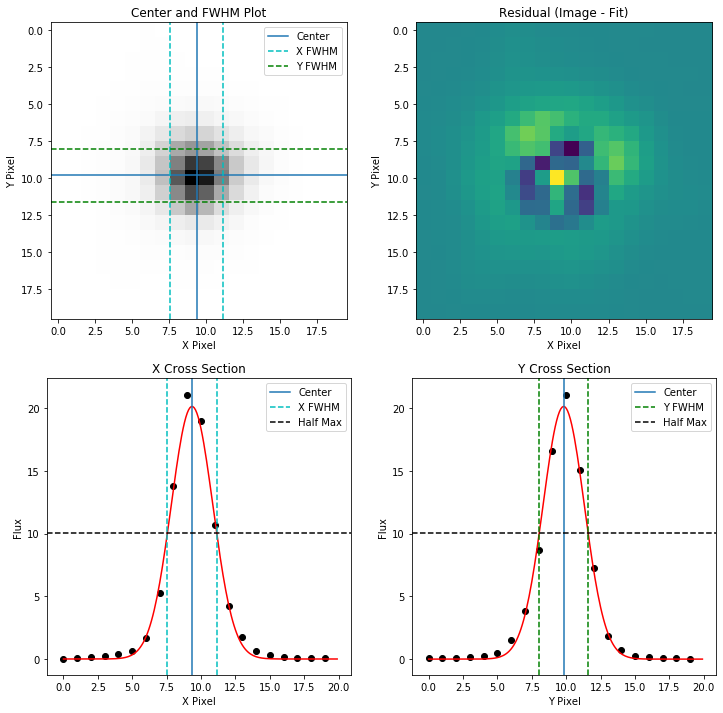

In [15]:
image = cutout(data, 3147, 6051, 20)
measure_fwhm(image);

Image Max: 0.013500000350177288
Amplitude: 0.014201277510232552
Center: (100.5333357551576, 100.14344690484623)
Sigma = (19.473023474163682, 18.63616846274745)
Mean FWHM: 45 Pix 
FWHM: (x=45.85546601431886, y=43.88482305865131) Pix 


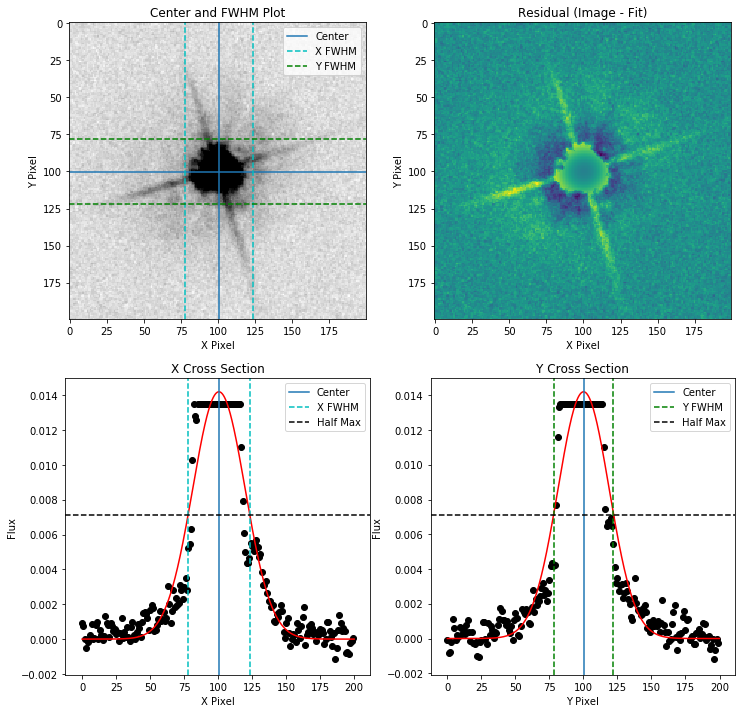

In [16]:
image = cutout(data, 3147, 6051, 200, vmax=mean_noise*300)
measure_fwhm(image);

### Dim star:

Same as above section but applied on a faint point like star

Image Max: 0.012927834875881672
Amplitude: 0.012187739419274314
Center: (13.896620315227112, 15.434422659046124)
Sigma = (1.7552660331858305, 2.057013921594196)
Mean FWHM: 4 Pix 
FWHM: (x=4.133335639307953, y=4.843897615477735) Pix 


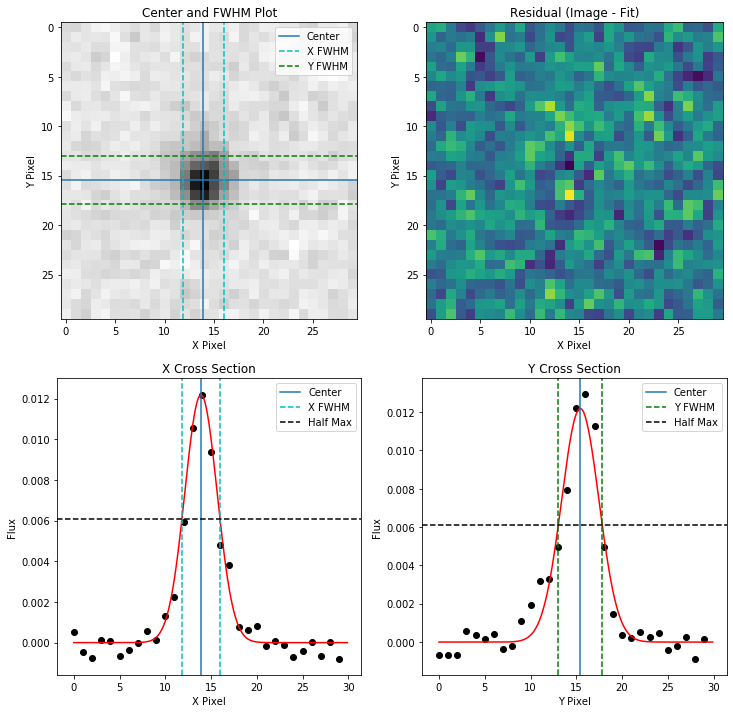

In [17]:
image = cutout(data, 7048, 5711, 30, vmax=mean_noise*300)
measure_fwhm(image, mean_noise);

### Measure FWHM for wide galaxy

Test function on extended sources

Image Max: 0.008999999612569809
Amplitude: 0.005581328255497077
Center: (151.38046500423883, 158.09514491722456)
Sigma = (31.95589802974823, 34.16345947276865)
Mean FWHM: 78 Pix 
FWHM: (x=75.25038923741616, y=80.44879917407809) Pix 


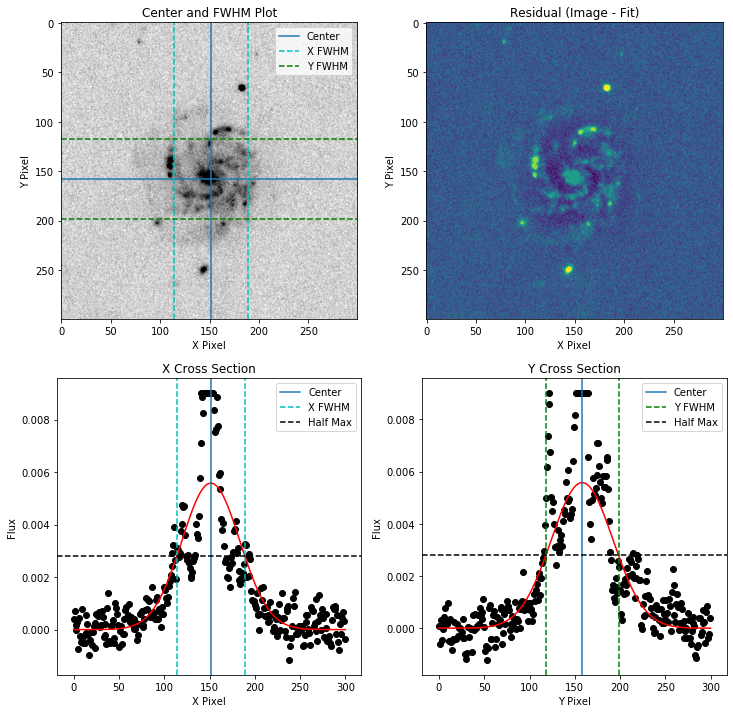

(75.25038923741616, 80.44879917407809)

In [18]:
image = cutout(data, 3124, 6479, 300, vmax=mean_noise*200)
measure_fwhm(image, mean_noise)

Image Max: 0.027000000700354576
Amplitude: 0.02394634981538754
Center: (155.65860762478857, 156.99152352520582)
Sigma = (31.169207429660133, 37.230031091755464)
Mean FWHM: 81 Pix 
FWHM: (x=73.39787444309128, y=87.67002349199124) Pix 


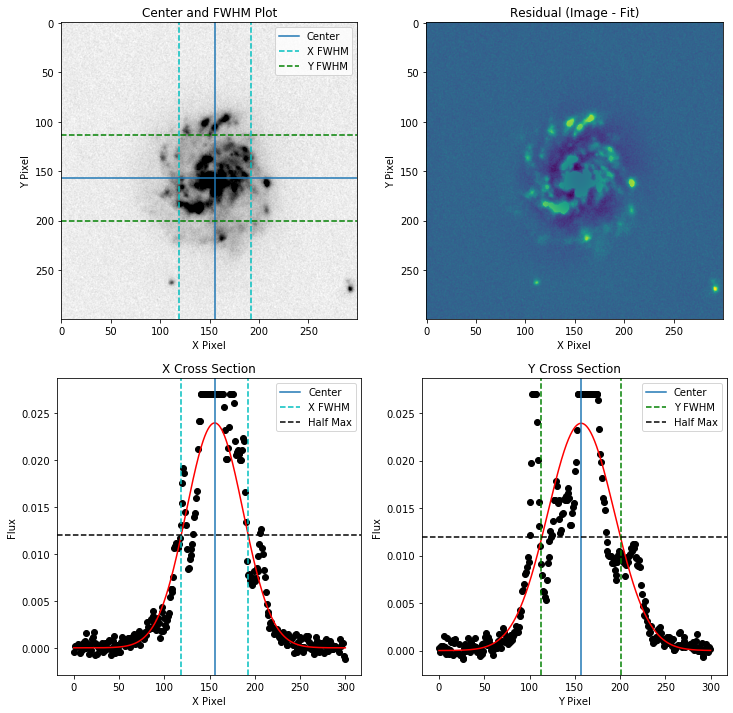

(73.39787444309128, 87.67002349199124)

In [19]:
image = cutout(data, 3595, 6377, 300, vmax=mean_noise*600)
measure_fwhm(image, mean_noise)

(300, 300)
Image Max: 0.0027000000700354576
Amplitude: 0.0025866213657610468
Center: (162.72082460811626, 144.36560123187033)
Sigma = (34.312231899805035, 9.606035671796668)
Mean FWHM: 52 Pix 
FWHM: (x=80.79913146741127, y=22.620485353229135) Pix 


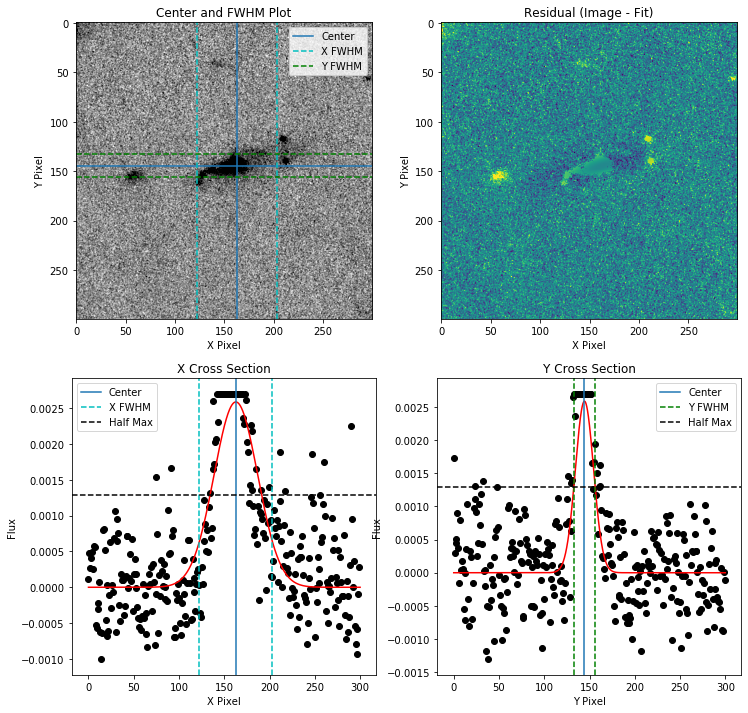

(80.79913146741127, 22.620485353229135)

In [20]:
image = cutout(data, 3330, 6220, 300, vmax=mean_noise*60)
print(image.shape)
measure_fwhm(image, mean_noise)